In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!pip install rasterio geopandas gdal tqdm

import rasterio
import geopandas as gpd
import numpy as np
import os
from rasterio.mask import mask
from shapely.geometry import mapping
from tqdm import tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 81.8 MB/s eta 0:00:00


In [ ]:
# 读取摩洛哥的shapefile
shapefile_path = "/content/drive/MyDrive/gadm41_MAR_0.shp"
morocco_shape = gpd.read_file(shapefile_path)
morocco_geom = [mapping(morocco_shape.geometry.union_all())]  # 修复 unary_union 弃用问题

In [ ]:
import rasterio
import numpy as np

tiff_path = "/content/drive/MyDrive/data_Macoc/SM.1km.Month.200002.Global.v001.tif"

with rasterio.open(tiff_path) as src:
    data = src.read(1)  # 读取第一个波段
    unique_values = np.unique(data)  # 获取数据中的唯一值
    print("裁剪后 TIFF 的唯一像元值:", unique_values)

    # 检查是否有 -1（原始 nodata）
    if -1 in unique_values:
        print("⚠️ 发现 -1，说明有 nodata")
    else:
        print("✅ 没有 -1，nodata 可能已经被处理")

    # 检查是否有 NaN
    if np.isnan(data).any():
        print("⚠️ 发现 NaN，说明存在 nodata")
    else:
        print("✅ 没有 NaN")


裁剪后 TIFF 的唯一像元值: [ -1   0  50  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156
 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174
 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192
 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246
 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264
 265 266 267 268 269 270 271 273 274 276 277 278 279 281 282 283 284 288
 289 291 295 298 299 300 312]
⚠️ 发

In [ ]:
import re

def extract_year_month(filename):
    # 假设文件名格式如 "SM.1km.Month.200005.Global.v001.tif"
    match = re.search(r"(\d{4})(\d{2})", filename)
    if match:
        year = int(match.group(1))
        month = int(match.group(2))
        return year, month
    else:
        raise ValueError(f"无法从文件名 {filename} 提取年份和月份")

In [ ]:
import os
import numpy as np
import rasterio
from tqdm import tqdm
from rasterio.windows import Window

# 路径配置
input_dir = "/content/drive/MyDrive/data_Macoc"  # 裁剪后的SM数据路径
output_dir = "/content/drive/MyDrive/SMCI_results1"
os.makedirs(output_dir, exist_ok=True)

import re

def extract_year_month(filename):
    # 假设文件名格式如 "SM.1km.Month.200005.Global.v001.tif"
    match = re.search(r"(\d{4})(\d{2})", filename)
    if match:
        year = int(match.group(1))
        month = int(match.group(2))
        return year, month
    else:
        raise ValueError(f"无法从文件名 {filename} 提取年份和月份")

# 第一步：按月份收集文件路径
month_files = {m: [] for m in range(1, 13)}
for filename in os.listdir(input_dir):
    if filename.endswith(".tif"):
        year, month = extract_year_month(filename)
        month_files[month].append((year, os.path.join(input_dir, filename)))

# 第二步：计算各月份的SM_min和SM_max
def calculate_month_stats(target_month):
    # 确定年份范围
    if target_month in [1, 2]:
        year_range = range(2001, 2021)  # 1-2月用2001-2020
    else:
        year_range = range(2000, 2021)  # 3-12月用2000-2020

    # 收集符合条件的文件
    valid_files = [
        path for yr, path in month_files[target_month]
        if yr in year_range
    ]

    # 初始化统计数组（以第一个文件为模板）
    with rasterio.open(valid_files[0]) as src:
        profile = src.profile
        sm_min = np.full(src.shape, np.inf, dtype=np.float32)
        sm_max = np.full(src.shape, -np.inf, dtype=np.float32)

    # 逐文件更新最值（内存友好方式）
    for path in tqdm(valid_files, desc=f"Processing Month {target_month:02d}"):
        with rasterio.open(path) as src:
            data = src.read(1).astype(np.float32)
            mask = (data != -1)  # 忽略-1，保留0
            np.minimum(sm_min, data, where=mask, out=sm_min)
            np.maximum(sm_max, data, where=mask, out=sm_max)

    # 处理全无效像素
    sm_min[sm_min == np.inf] = -1
    sm_max[sm_max == -np.inf] = -1
    return sm_min, sm_max

# 第三步：预计算所有月份的最值
month_stats = {}
for month in range(1, 13):
    sm_min, sm_max = calculate_month_stats(month)
    month_stats[month] = (sm_min, sm_max)

# 第四步：计算每个文件的SMCI
for filename in tqdm(os.listdir(input_dir), desc="Calculating SMCI"):
    if filename.endswith(".tif"):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, f"SMCI_{filename}")

        year, month = extract_year_month(filename)

        # 跳过2000年1-2月（根据需求可选是否生成占位文件）
        if year == 2000 and month in [1, 2]:
            continue

        # 获取对应月份的最值
        sm_min, sm_max = month_stats[month]

        with rasterio.open(input_path) as src:
            profile = src.profile
            data = src.read(1).astype(np.float32)

            # 计算SMCI
            denominator = sm_max - sm_min
            valid_mask = (data != -1) & (denominator != 0) & (denominator != -2)  # -2来自sm_max-sm_min=-1-(-1)
            smci = np.full_like(data, -1)  # 默认-1
            smci[valid_mask] = (data[valid_mask] - sm_min[valid_mask]) / denominator[valid_mask]

            # 确保0值保留
            zero_mask = (data == 0) & (denominator != 0) & (denominator != -2)
            smci[zero_mask] = (0 - sm_min[zero_mask]) / denominator[zero_mask]

            # 写入结果
            profile.update(dtype=rasterio.float32, nodata=-1)
            with rasterio.open(output_path, "w", **profile) as dst:
                dst.write(smci.astype(np.float32), 1)

Calculating SMCI: 100%|██████████| 251/251 [00:53<00:00,  4.73it/s]


In [ ]:
import os
import numpy as np
import rasterio
from tqdm import tqdm
import re

# 路径配置
input_dir = "/content/drive/MyDrive/data_Macoc"  # 裁剪后的SM数据路径
output_dir = "/content/drive/MyDrive/SMCI_results_fixed"
os.makedirs(output_dir, exist_ok=True)

# 解析年份和月份
def extract_year_month(filename):
    match = re.search(r"(\d{4})(\d{2})", filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    raise ValueError(f"无法从文件名 {filename} 提取年份和月份")

# 按月份收集文件
month_files = {m: [] for m in range(1, 13)}
for filename in os.listdir(input_dir):
    if filename.endswith(".tif"):
        year, month = extract_year_month(filename)
        month_files[month].append((year, os.path.join(input_dir, filename)))

# 计算各月份的SM_min和SM_max
def calculate_month_stats(target_month):
    if target_month in [1, 2]:
        year_range = range(2001, 2021)  # 1-2月用2001-2020
    else:
        year_range = range(2000, 2021)  # 3-12月用2000-2020

    valid_files = [path for yr, path in month_files[target_month] if yr in year_range]

    with rasterio.open(valid_files[0]) as src:
        profile = src.profile
        sm_min = np.full(src.shape, np.inf, dtype=np.float32)
        sm_max = np.full(src.shape, -np.inf, dtype=np.float32)

    for path in tqdm(valid_files, desc=f"Processing Month {target_month:02d}"):
        with rasterio.open(path) as src:
            data = src.read(1).astype(np.float32)

            # 排除 -1（nodata）和 0 值
            mask = (data != -1) & (data != 0)
            np.minimum(sm_min, data, where=mask, out=sm_min)
            np.maximum(sm_max, data, where=mask, out=sm_max)

    # 处理无效值
    sm_min[sm_min == np.inf] = -1
    sm_max[sm_max == -np.inf] = -1
    return sm_min, sm_max

# 预计算所有月份的最值
month_stats = {}
for month in range(1, 13):
    sm_min, sm_max = calculate_month_stats(month)
    month_stats[month] = (sm_min, sm_max)

# 计算 SMCI
for filename in tqdm(os.listdir(input_dir), desc="Calculating SMCI"):
    if filename.endswith(".tif"):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, f"SMCI_{filename}")

        year, month = extract_year_month(filename)

        # 跳过 2000 年 1-2 月
        if year == 2000 and month in [1, 2]:
            continue

        # 获取 SM_min 和 SM_max
        sm_min, sm_max = month_stats[month]

        with rasterio.open(input_path) as src:
            profile = src.profile
            data = src.read(1).astype(np.float32)

            # 计算 SMCI
            denominator = sm_max - sm_min
            valid_mask = (data != -1) & (denominator != 0) & (denominator != -2)
            smci = np.full_like(data, -1)  # 默认 -1
            smci[valid_mask] = (data[valid_mask] - sm_min[valid_mask]) / denominator[valid_mask]

            # 让 0 仍然有效
            zero_mask = (data == 0) & (denominator != 0) & (denominator != -2)
            smci[zero_mask] = (0 - sm_min[zero_mask]) / denominator[zero_mask]

            # 写入结果
            profile.update(dtype=rasterio.float32, nodata=-1)
            with rasterio.open(output_path, "w", **profile) as dst:
                dst.write(smci.astype(np.float32), 1)

print("✅ SMCI 计算完成，结果保存在:", output_dir)


Calculating SMCI: 100%|██████████| 251/251 [00:24<00:00, 10.13it/s]

✅ SMCI 计算完成，结果保存在: /content/drive/MyDrive/SMCI_results_fixed


In [ ]:
def calculate_month_stats(target_month):
    # 确定年份范围
    if target_month in [1, 2]:
        year_range = range(2001, 2021)  # 1-2月用2001-2020
    else:
        year_range = range(2000, 2021)  # 3-12月用2000-2020

    # 收集符合条件的文件
    valid_files = [
        path for yr, path in month_files[target_month]
        if yr in year_range
    ]

    # 初始化统计数组（以第一个文件为模板）
    with rasterio.open(valid_files[0]) as src:
        profile = src.profile
        sm_min = np.full(src.shape, np.inf, dtype=np.float32)
        sm_max = np.full(src.shape, -np.inf, dtype=np.float32)

    # 逐文件更新最值
    for path in tqdm(valid_files, desc=f"Processing Month {target_month:02d}"):
        with rasterio.open(path) as src:
            data = src.read(1).astype(np.float32)

            # 只考虑有效值：>0 且 ≠ -1
            valid_min_mask = (data > 0) & (data != -1)
            valid_max_mask = (data != -1)  # 只排除 -1，保留 0

            np.minimum(sm_min, data, where=valid_min_mask, out=sm_min)
            np.maximum(sm_max, data, where=valid_max_mask, out=sm_max)

    # 处理全无效像素
    sm_min[sm_min == np.inf] = -1  # 说明该像素点从未有有效数据
    sm_max[sm_max == -np.inf] = -1

    return sm_min, sm_max



In [ ]:
import numpy as np

for month in range(1, 13):
    sm_min, sm_max = month_stats[month]

    print(f"--- {month:02d} 月 ---")
    print(f"SM_min 取值范围: {np.min(sm_min)} - {np.max(sm_min)}")
    print(f"SM_max 取值范围: {np.min(sm_max)} - {np.max(sm_max)}")
    print(f"SM_max - SM_min 取值范围: {np.min(sm_max - sm_min)} - {np.max(sm_max - sm_min)}")
    print()


--- 01 月 ---
SM_min 取值范围: -1.0 - 359.0
SM_max 取值范围: -1.0 - 406.0
SM_max - SM_min 取值范围: 0.0 - 286.0

--- 02 月 ---
SM_min 取值范围: -1.0 - 321.0
SM_max 取值范围: -1.0 - 395.0
SM_max - SM_min 取值范围: 0.0 - 282.0

--- 03 月 ---
SM_min 取值范围: -1.0 - 289.0
SM_max 取值范围: -1.0 - 393.0
SM_max - SM_min 取值范围: 0.0 - 281.0

--- 04 月 ---
SM_min 取值范围: -1.0 - 293.0
SM_max 取值范围: -1.0 - 379.0
SM_max - SM_min 取值范围: 0.0 - 252.0

--- 05 月 ---
SM_min 取值范围: -1.0 - 284.0
SM_max 取值范围: -1.0 - 352.0
SM_max - SM_min 取值范围: 0.0 - 238.0

--- 06 月 ---
SM_min 取值范围: -1.0 - 247.0
SM_max 取值范围: -1.0 - 308.0
SM_max - SM_min 取值范围: 0.0 - 181.0

--- 07 月 ---
SM_min 取值范围: -1.0 - 281.0
SM_max 取值范围: -1.0 - 309.0
SM_max - SM_min 取值范围: 0.0 - 180.0

--- 08 月 ---
SM_min 取值范围: -1.0 - 288.0
SM_max 取值范围: -1.0 - 308.0
SM_max - SM_min 取值范围: 0.0 - 179.0

--- 09 月 ---
SM_min 取值范围: -1.0 - 239.0
SM_max 取值范围: -1.0 - 307.0
SM_max - SM_min 取值范围: 0.0 - 225.0

--- 10 月 ---
SM_min 取值范围: -1.0 - 267.0
SM_max 取值范围: -1.0 - 345.0
SM_max - SM_min 取值范围: 0.0 - 233.0



In [ ]:
import os
import numpy as np
import rasterio
from tqdm import tqdm
import re

# 路径配置
input_dir = "/content/drive/MyDrive/data_Macoc"  # 已经裁剪后的SM数据路径
output_dir = "/content/drive/MyDrive/SMCI_results_try"
os.makedirs(output_dir, exist_ok=True)

def extract_year_month(filename):
    """
    从文件名中提取年份和月份
    假设文件名格式如 "SM.1km.Month.200005.Global.v001.tif"
    """
    match = re.search(r"(\d{4})(\d{2})", filename)
    if match:
        year = int(match.group(1))
        month = int(match.group(2))
        return year, month
    else:
        raise ValueError(f"无法从文件名 {filename} 提取年份和月份")

# 第一步：按月份收集文件路径（存放为 (year, filepath) 的元组）
month_files = {m: [] for m in range(1, 13)}
for filename in os.listdir(input_dir):
    if filename.endswith(".tif"):
        year, month = extract_year_month(filename)
        month_files[month].append((year, os.path.join(input_dir, filename)))

# 第二步：计算各月份的 SM_min 和 SM_max
def calculate_month_stats(target_month):
    """
    计算目标月份（target_month）所有文件的逐像元最小值和最大值，
    忽略数据中值为 -1 的像元。
    """
    # 根据需求确定年份范围
    if target_month in [1, 2]:
        year_range = range(2001, 2021)  # 1-2月用2001-2020
    else:
        year_range = range(2000, 2021)  # 3-12月用2000-2021

    # 收集符合条件的文件
    valid_files = [
        path for yr, path in month_files[target_month]
        if yr in year_range
    ]

    # 初始化统计数组（以第一个文件为模板）
    with rasterio.open(valid_files[0]) as src:
        sm_min = np.full(src.shape, np.inf, dtype=np.float32)
        sm_max = np.full(src.shape, -np.inf, dtype=np.float32)

    # 逐文件更新最值（内存友好方式）
    for path in tqdm(valid_files, desc=f"Processing Month {target_month:02d}"):
        with rasterio.open(path) as src:
            data = src.read(1).astype(np.float32)
            # 忽略-1值（nodata），保留0及其他有效值
            mask = (data != -1)
            np.minimum(sm_min, data, where=mask, out=sm_min)
            np.maximum(sm_max, data, where=mask, out=sm_max)

    # 对全无效像元（仍为初始值）做处理：赋值为 -1
    sm_min[sm_min == np.inf] = -1
    sm_max[sm_max == -np.inf] = -1
    return sm_min, sm_max

# 第三步：预计算所有月份的最值
month_stats = {}
for month in range(1, 13):
    sm_min, sm_max = calculate_month_stats(month)
    month_stats[month] = (sm_min, sm_max)
# 计算 SMCI
denominator = sm_max - sm_min

# 只在 SM_min > 0, SM_max ≠ -1, 数据值 ≠ -1 且 ≠ 0 的地方计算
valid_mask = (data > 0) & (data != -1) & (sm_min > 0) & (sm_min != -1) & (denominator > 0)

smci = np.full_like(data, -1)  # 默认值填充 -1
smci[valid_mask] = (data[valid_mask] - sm_min[valid_mask]) / denominator[valid_mask]

# 第四步：计算每个文件的 SMCI
for filename in tqdm(os.listdir(input_dir), desc="Calculating SMCI"):
    if filename.endswith(".tif"):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, f"SMCI_{filename}")

        year, month = extract_year_month(filename)
        # 跳过2000年1-2月（根据需求，可选是否生成占位文件）
        if year == 2000 and month in [1, 2]:
            continue

        # 获取对应月份的最值
        sm_min, sm_max = month_stats[month]

        with rasterio.open(input_path) as src:
            profile = src.profile
            data = src.read(1).astype(np.float32)

            # 计算分母（注意可能有无效区域，因此除零情况需特殊处理）
            denominator = sm_max - sm_min

            # 构造有效掩膜：忽略 -1 值，且除数不为0和不为-2（后者来源于 -1 - (-1)）
            valid_mask = (data != -1) & (denominator != 0) & (denominator != -2)
            smci = np.full_like(data, -1, dtype=np.float32)  # 默认无效值设为 -1

            # 对有效数据计算 SMCI
            smci[valid_mask] = (data[valid_mask] - sm_min[valid_mask]) / denominator[valid_mask]

            # 保证如果数据为0时，结果也按照公式计算
            zero_mask = (data == 0) & (denominator != 0) & (denominator != -2)
            smci[zero_mask] = (0 - sm_min[zero_mask]) / denominator[zero_mask]

            # 新增修改：如果对应像元的历史最小值和最大值均为0，则SMCI应为0
            all_zero_mask = (sm_min == 0) & (sm_max == 0)
            smci[all_zero_mask] = 0

            # 写入结果，更新元数据（nodata设为 -1）
            profile.update(dtype=rasterio.float32, nodata=-1)
            with rasterio.open(output_path, "w", **profile) as dst:
                dst.write(smci.astype(np.float32), 1)

print("✅ SMCI 计算完成，结果保存在:", output_dir)



Calculating SMCI: 100%|██████████| 251/251 [00:46<00:00,  5.44it/s]

✅ SMCI 计算完成，结果保存在: /content/drive/MyDrive/SMCI_results_try


In [ ]:
import os
import numpy as np
import rasterio
from tqdm import tqdm
import re

# 路径配置
input_dir = "/content/drive/MyDrive/data_Macoc"  # 已裁剪的 SM 数据路径
output_dir = "/content/drive/MyDrive/SMCI_results_fixed"
os.makedirs(output_dir, exist_ok=True)

def extract_year_month(filename):
    """从文件名中提取年份和月份"""
    match = re.search(r"(\d{4})(\d{2})", filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    else:
        raise ValueError(f"无法从文件名 {filename} 提取年份和月份")

# 第一步：按月份收集文件路径
month_files = {m: [] for m in range(1, 13)}
for filename in os.listdir(input_dir):
    if filename.endswith(".tif"):
        year, month = extract_year_month(filename)
        month_files[month].append((year, os.path.join(input_dir, filename)))

# 第二步：计算各月份的 SM_min 和 SM_max
def calculate_month_stats(target_month):
    """计算目标月份的 SM_min 和 SM_max，忽略 -1 和 0"""
    # 确定年份范围
    year_range = range(2001, 2021) if target_month in [1, 2] else range(2000, 2021)

    # 过滤符合条件的文件
    valid_files = [path for yr, path in month_files[target_month] if yr in year_range]

    if not valid_files:
        raise ValueError(f"⚠️ 无有效数据用于计算 {target_month} 月的 SM_min 和 SM_max！")

    # 初始化 min/max 数组
    with rasterio.open(valid_files[0]) as src:
        sm_min = np.full(src.shape, np.inf, dtype=np.float32)
        sm_max = np.full(src.shape, -np.inf, dtype=np.float32)

    # 遍历文件，更新最值
    for path in tqdm(valid_files, desc=f"Processing Month {target_month:02d}"):
        with rasterio.open(path) as src:
            data = src.read(1).astype(np.float32)
            mask = (data > 0)  # 忽略 -1 和 0

            np.minimum(sm_min, data, where=mask, out=sm_min)
            np.maximum(sm_max, data, where=mask, out=sm_max)

    # 处理全无效像素
    sm_min[sm_min == np.inf] = -1
    sm_max[sm_max == -np.inf] = -1
    return sm_min, sm_max

# 第三步：预计算所有月份的最值
month_stats = {m: calculate_month_stats(m) for m in range(1, 13)}

# 第四步：计算 SMCI
for filename in tqdm(os.listdir(input_dir), desc="Calculating SMCI"):
    if filename.endswith(".tif"):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, f"SMCI_{filename}")

        year, month = extract_year_month(filename)

        # 跳过 2000 年 1-2 月
        if year == 2000 and month in [1, 2]:
            continue

        # 读取 SM 数据
        with rasterio.open(input_path) as src:
            profile = src.profile
            data = src.read(1).astype(np.float32)

            # 获取该月份的 SM_min 和 SM_max
            sm_min, sm_max = month_stats[month]
            denominator = sm_max - sm_min

            # 计算 SMCI（过滤无效值）
            valid_mask = (data > 0) & (data != -1) & (sm_min > 0) & (denominator > 0)
            smci = np.full_like(data, -1, dtype=np.float32)  # 默认填充 -1
            smci[valid_mask] = (data[valid_mask] - sm_min[valid_mask]) / denominator[valid_mask]

            # 处理所有历史最值都为 0 的区域
            smci[(sm_min == 0) & (sm_max == 0)] = -1  # 设为 -1 而非 0，以防误解

            # 写入结果
            profile.update(dtype=rasterio.float32, nodata=-1)
            with rasterio.open(output_path, "w", **profile) as dst:
                dst.write(smci, 1)

print("✅ SMCI 计算完成，结果保存在:", output_dir)


Calculating SMCI: 100%|██████████| 251/251 [00:54<00:00,  4.64it/s]

✅ SMCI 计算完成，结果保存在: /content/drive/MyDrive/SMCI_results_fixed


In [ ]:
import os
import numpy as np
import rasterio
from tqdm import tqdm
import re

# 路径配置
input_dir = "/content/drive/MyDrive/data_Macoc"  # 裁剪后的SM数据路径
output_dir = "/content/drive/MyDrive/SMCI_results_02"
os.makedirs(output_dir, exist_ok=True)

# 辅助函数：提取年份和月份
def extract_year_month(filename):
    match = re.search(r"(\d{4})(\d{2})", filename)
    if match:
        year = int(match.group(1))
        month = int(match.group(2))
        return year, month
    else:
        raise ValueError(f"无法从文件名 {filename} 提取年份和月份")

# 第一步：按月份收集文件路径
month_files = {m: [] for m in range(1, 13)}
for filename in os.listdir(input_dir):
    if filename.endswith(".tif"):
        year, month = extract_year_month(filename)
        month_files[month].append((year, os.path.join(input_dir, filename)))

# 第二步：计算各月份的SM_min和SM_max
def calculate_month_stats(target_month):
    # 确定年份范围
    if target_month in [1, 2]:
        year_range = range(2001, 2021)  # 1-2月用2001-2020
    else:
        year_range = range(2000, 2021)  # 3-12月用2000-2020

    # 收集符合条件的文件
    valid_files = [path for yr, path in month_files[target_month] if yr in year_range]

    # 初始化统计数组
    with rasterio.open(valid_files[0]) as src:
        profile = src.profile
        sm_min = np.full(src.shape, np.inf, dtype=np.float32)
        sm_max = np.full(src.shape, -np.inf, dtype=np.float32)

    # 逐文件更新最值
    for path in tqdm(valid_files, desc=f"Processing Month {target_month:02d}"):
        with rasterio.open(path) as src:
            data = src.read(1).astype(np.float32)
            mask = (data != -1)  # 忽略 nodata 值（-1）
            np.minimum(sm_min, data, where=mask, out=sm_min)
            np.maximum(sm_max, data, where=mask, out=sm_max)

    # 处理无效像素
    sm_min[sm_min == np.inf] = -1
    sm_max[sm_max == -np.inf] = -1
    return sm_min, sm_max

# 第三步：预计算所有月份的最值
month_stats = {}
for month in range(1, 13):
    sm_min, sm_max = calculate_month_stats(month)
    month_stats[month] = (sm_min, sm_max)

# 第四步：计算每个文件的SMCI
for filename in tqdm(os.listdir(input_dir), desc="Calculating SMCI"):
    if filename.endswith(".tif"):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, f"SMCI_{filename}")

        year, month = extract_year_month(filename)

        # 跳过2000年1-2月
        if year == 2000 and month in [1, 2]:
            continue

        # 获取对应月份的最值
        sm_min, sm_max = month_stats[month]

        with rasterio.open(input_path) as src:
            profile = src.profile
            data = src.read(1).astype(np.float32)

            # 计算SMCI
            denominator = sm_max - sm_min
            smci = np.full_like(data, -1, dtype=np.float32)  # 默认设为 nodata 值 -1

            # **(1) 计算正常SMCI**
            valid_mask = (data != -1) & (denominator != 0) & (denominator != -2)
            smci[valid_mask] = (data[valid_mask] - sm_min[valid_mask]) / denominator[valid_mask]

            # **(2) 处理0值情况**
            zero_mask = (data == 0) & (denominator != 0) & (denominator != -2)
            smci[zero_mask] = (0 - sm_min[zero_mask]) / denominator[zero_mask]

            # **(3) 处理最大值和最小值都为 0 的情况**
            zero_range_mask = (sm_max == 0) & (sm_min == 0)
            smci[zero_range_mask] = 0.0  # 确保SMCI为0

            # 写入结果
            profile.update(dtype=rasterio.float32, nodata=-1)
            with rasterio.open(output_path, "w", **profile) as dst:
                dst.write(smci.astype(np.float32), 1)


Calculating SMCI: 100%|██████████| 251/251 [00:48<00:00,  5.13it/s]


文件中的 nodata 值: -1.0
数据中的唯一值: [-1.          0.          0.00515464 ...  0.9936306   0.9939394
  1.        ]


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30452 (\N{CJK UNIFIED IDEOGRAPH-76F4}) missing from font(s) DejaVu Sans.
  fig.canvas

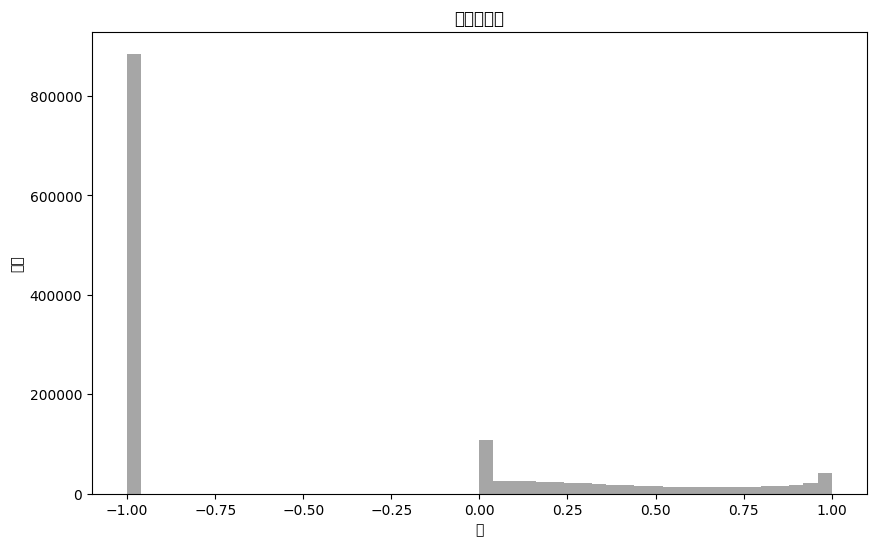

0 值占比: 5.91%
-1 值占比: 61.08%
nodata 值占比: 61.08%


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# 选择一个剪裁后的文件进行检查
tiff_path = "/content/drive/MyDrive/SMCI_results_fixed/SMCI_SM.1km.Month.200003.Global.v001.tif"

# 读取数据
with rasterio.open(tiff_path) as src:
    data = src.read(1)  # 读取第一个波段
    nodata_value = src.nodata  # 获取 nodata 值
    print(f"文件中的 nodata 值: {nodata_value}")

    # 检查数据的唯一值
    unique_values = np.unique(data)
    print(f"数据中的唯一值: {unique_values}")

    # 创建直方图
    plt.figure(figsize=(10, 6))
    plt.hist(data.flatten(), bins=50, range=(np.nanmin(data), np.nanmax(data)), color='gray', alpha=0.7)
    plt.title("数据直方图")
    plt.xlabel("值")
    plt.ylabel("频率")
    plt.show()

    # 计算 0 和 -1 值的占比
    zero_count = np.sum(data == 0)
    minus_one_count = np.sum(data == -1)
    total_pixels = data.size

    print(f"0 值占比: {zero_count / total_pixels * 100:.2f}%")
    print(f"-1 值占比: {minus_one_count / total_pixels * 100:.2f}%")

    # 检查 nodata 的影响范围
    nodata_data = np.sum(data == nodata_value)
    print(f"nodata 值占比: {nodata_data / total_pixels * 100:.2f}%")


In [ ]:
import rasterio
import numpy as np

# 读取一个示例文件
tif_file = "/content/drive/MyDrive/SMCI_results_fixed/SMCI_SM.1km.Month.200003.Global.v001.tif"  # 替换为你的实际文件路径

with rasterio.open(tif_file) as src:
    print("文件元数据:", src.meta)
    print("nodata 值:", src.nodata)

    # 读取数据并转换为浮点型
    sm_data = src.read(1).astype(np.float32)

    # 计算数据范围
    min_val = np.nanmin(sm_data)
    max_val = np.nanmax(sm_data)
    print(f"数据范围（未缩放）: min={min_val}, max={max_val}")

    # 处理 nodata
    sm_data[sm_data == src.nodata] = np.nan

    # 重新计算数据范围
    min_val = np.nanmin(sm_data)
    max_val = np.nanmax(sm_data)
    print(f"数据范围（处理 nodata 后）: min={min_val}, max={max_val}")

    # 应用缩放因子
    sm_data = sm_data * 0.001
    min_val = np.nanmin(sm_data)
    max_val = np.nanmax(sm_data)
    print(f"数据范围（应用缩放因子后）: min={min_val}, max={max_val}")


文件元数据: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1.0, 'width': 1462, 'height': 991, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.008333333333333333, 0.0, -13.175000000000011,
       0.0, -0.008333333333333333, 35.925)}
nodata 值: -1.0
数据范围（未缩放）: min=-1.0, max=1.0
数据范围（处理 nodata 后）: min=0.0, max=1.0
数据范围（应用缩放因子后）: min=0.0, max=0.0010000000474974513


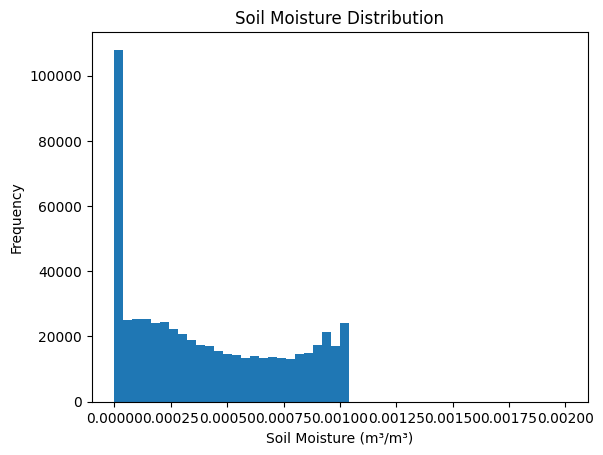

In [ ]:
import matplotlib.pyplot as plt

plt.hist(sm_data.flatten(), bins=50, range=(0, 0.002))
plt.xlabel("Soil Moisture (m³/m³)")
plt.ylabel("Frequency")
plt.title("Soil Moisture Distribution")
plt.show()


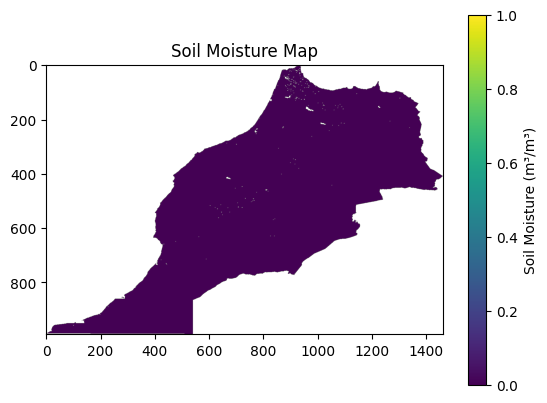

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(sm_data, cmap="viridis", vmin=0, vmax=1)
plt.colorbar(label="Soil Moisture (m³/m³)")
plt.title("Soil Moisture Map")
plt.show()


In [ ]:
import os
import numpy as np
import rasterio
from rasterio.mask import mask
from tqdm import tqdm
import re

# 输入和输出路径
cropped_dir = "/content/drive/MyDrive/data_Macoc"
output_dir = "/content/drive/MyDrive/SoilMoisture_Morocco_SMCI"
os.makedirs(output_dir, exist_ok=True)


# 提取月份信息的正则表达式
month_pattern = re.compile(r"\.(\d{6})\.")  # 例如 "SM.1km.Month.200101.Global.v001.tif" -> 200101

# 读取所有裁剪后的文件
tif_files = [f for f in os.listdir(cropped_dir) if f.endswith(".tif")]

# 按月份分组
monthly_data = {}
for filename in tif_files:
    match = month_pattern.search(filename)
    if match:
        year_month = match.group(1)  # 200101, 200102, ...
        month = year_month[-2:]  # 提取月份部分
        if int(year_month[:4]) == 2000:  # 跳过 2000 年 1 月
            continue
        if month not in monthly_data:
            monthly_data[month] = []
        monthly_data[month].append(os.path.join(cropped_dir, filename))

# 计算 SMCI
for month, file_list in tqdm(monthly_data.items(), desc="Processing SMCI"):
    sm_stack = []

    # 读取所有相同月份的土壤湿度数据
    for file in file_list:
        with rasterio.open(file) as src:
            sm_data = src.read(1).astype(np.float32)  # 转换为 float32
            sm_data[sm_data == src.nodata] = np.nan  # 处理 nodata 值
            sm_stack.append(sm_data)

    sm_stack = np.array(sm_stack)  # 形状 (年数, 高度, 宽度)

    # 计算 SMmax 和 SMmin（同一月份所有年份的最值）
    SMmax = np.nanmax(sm_stack, axis=0)  # 最大值
    SMmin = np.nanmin(sm_stack, axis=0)  # 最小值

    # 避免除零错误（整数 TIFF 不能存储 NaN，所以必须转换）
    denominator = SMmax - SMmin
    denominator[denominator == 0] = np.nan  # 防止除零

    # 遍历当前月份所有年份的文件，计算 SMCI
    for file in file_list:
        with rasterio.open(file) as src:
            SMi = src.read(1).astype(np.float32)  # 读取并转换为 float32
            SMi[SMi == src.nodata] = np.nan  # 处理 nodata 值

            SMCI = (SMi - SMmin) / denominator  # 计算 SMCI

            # 生成输出文件名
            output_filename = os.path.join(output_dir, "SMCI_" + os.path.basename(file))

            # 保存 SMCI 结果（确保数据类型是 float32）
            out_meta = src.meta.copy()
            out_meta.update({"dtype": "float32", "nodata": np.nan})

            with rasterio.open(output_filename, "w", **out_meta) as dest:
                dest.write(SMCI, 1)

print("✅ SMCI 计算完成，数据保存在:", output_dir)


Processing SMCI: 100%|██████████| 12/12 [01:23<00:00,  6.93s/it]

✅ SMCI 计算完成，数据保存在: /content/drive/MyDrive/SoilMoisture_Morocco_SMCI


In [ ]:
!pip install rasterstats
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 4.4 MB/s eta 0:00:00


In [ ]:
import geopandas as gpd
import rasterio

# 读取 Shapefile
shapefile_path = "/content/drive/MyDrive/gadm41_MAR_2.shp"
provinces = gpd.read_file(shapefile_path)
print("Shapefile 坐标系:", provinces.crs)

# 读取 TIFF 栅格数据（选取一个示例文件）
tif_path = "/content/drive/MyDrive/data_Macoc/SM.1km.Month.200002.Global.v001.tif"
with rasterio.open(tif_path) as src:
    print("TIFF 坐标系:", src.crs)


Shapefile 坐标系: EPSG:4326
TIFF 坐标系: EPSG:4326


In [ ]:
!pip install geopandas
!pip install rasterstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 8.9 MB/s eta 0:00:00


In [ ]:
import os
import re
import numpy as np
import rasterio
import geopandas as gpd
import pandas as pd
from rasterstats import zonal_stats
from tqdm import tqdm

# 输入数据路径
output_dir = "/content/drive/MyDrive/SMCI_results_fixed"  # SMCI 结果栅格文件夹
shapefile_path = "/content/drive/MyDrive/shp/studyarea.geojson"  # 省级行政区 shapefile
csv_output_path = "/content/drive/MyDrive/SMCI_results_province.csv"  # 目标 CSV

# 读取 shapefile
gdf = gpd.read_file(shapefile_path)
province_col = "NAME_2"  # 省份字段，可能需要调整

# 存储结果
data_list = []

# 提取年、月
def extract_metadata(filename):
    """从文件名提取 年份 和 月份"""
    match = re.search(r"(\d{4})(\d{2})", filename)  # 识别 YYYYMM
    if match:
        return int(match.group(1)), int(match.group(2))
    raise ValueError(f"无法解析 {filename} 的年份和月份")

# 遍历所有 SMCI 结果文件
for filename in tqdm(os.listdir(output_dir), desc="Processing SMCI files"):
    if filename.endswith(".tif"):
        file_path = os.path.join(output_dir, filename)

        # 提取 年、月
        try:
            year, month = extract_metadata(filename)
        except ValueError as e:
            print(e)
            continue

        # 计算省级均值
        stats = zonal_stats(gdf, file_path, stats=["mean"], nodata=-1)

        # 存入列表
        for i, province in enumerate(gdf[province_col]):
            smci_mean = stats[i]["mean"] if stats[i]["mean"] is not None else -1
            data_list.append([year, month, province, smci_mean])

# 转换为 DataFrame 并保存
df = pd.DataFrame(data_list, columns=["Year", "Month", "Province", "SMCI_mean"])
df.to_csv(csv_output_path, index=False)

print("✅ CSV 生成完成:", csv_output_path)


Processing SMCI files: 100%|██████████| 251/251 [03:11<00:00,  1.31it/s]

✅ CSV 生成完成: /content/drive/MyDrive/SMCI_results_province.csv


In [ ]:
import os
import re
import numpy as np
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import pandas as pd
from tqdm import tqdm

# 路径配置
shapefile_path = "/content/drive/MyDrive/shp/gadm41_MAR_2.shp"  # 省级行政区划数据
smci_dir = "/content/drive/MyDrive/SMCI_results"  # SMCI栅格目录
output_csv = "/content/drive/MyDrive/SoilMoisture_Morocco_SMCI_Provinces1.csv"  # 输出结果

# 读取行政区划数据并验证字段名
provinces = gpd.read_file(shapefile_path)
province_name_field = "NAME_2"  # 请检查字段名是否匹配（如 NAME_1, NAME_FR 等）
assert province_name_field in provinces.columns, f"字段 {province_name_field} 不存在，可用字段: {provinces.columns.tolist()}"

# 初始化结果存储
results = []

# 遍历所有SMCI文件
tif_files = sorted([f for f in os.listdir(smci_dir) if f.endswith(".tif")])

for tif in tqdm(tif_files, desc="计算省级平均SMCI"):
    tif_path = os.path.join(smci_dir, tif)

    # 提取年月信息（正则匹配6位数字，如200101）
    match = re.search(r"(\d{6})", tif)
    if not match:
        print(f"⚠️ 文件名 {tif} 格式不符，跳过")
        continue
    month_str = match.group(1)

    try:
        # 计算区域统计（忽略nodata=-1）
        stats = zonal_stats(
            provinces,  # 直接传入GeoDataFrame
            tif_path,
            stats=["mean"],
            nodata=-1,  # 假设SMCI的nodata值为-1
            affine=None,  # 自动从栅格读取
            all_touched=False  # 仅统计像元中心在面内的值
        )

        # 保存结果
        for idx, row in provinces.iterrows():
            province_name = row[province_name_field]
            mean_value = stats[idx]["mean"]
            results.append([month_str, province_name, mean_value])

    except Exception as e:
        print(f"处理文件 {tif} 失败: {e}")

# 转换为DataFrame并保存
df = pd.DataFrame(results, columns=["Month", "Province", "SMCI_Mean"])
df.to_csv(output_csv, index=False)

print(f"✅ 处理完成！结果保存至 {output_csv}")


计算省级平均SMCI: 100%|██████████| 250/250 [06:37<00:00,  1.59s/it]

✅ 处理完成！结果保存至 /content/drive/MyDrive/SoilMoisture_Morocco_SMCI_Provinces1.csv


In [ ]:
import os
import re
import numpy as np
import geopandas as gpd
from rasterstats import zonal_stats
import pandas as pd
from tqdm import tqdm

# 设置路径
shapefile_path = "/content/drive/MyDrive/shp/gadm41_MAR_2.shp"  # 省级 Shapefile
smci_dir = "/content/drive/MyDrive/SoilMoisture_Morocco_SMCI"  # SMCI 栅格数据所在目录
output_csv = "/content/drive/MyDrive/SoilMoisture_Morocco_SMCI_Provinces3.csv"

# 读取 Shapefile，并检查省名字段
zones = gpd.read_file(shapefile_path)
print("Unique provinces:", zones["NAME_2"].unique())

# 将 GeoDataFrame 转换为 GeoJSON 格式的 features 列表
zones_geojson = zones.__geo_interface__['features']

# 定义正则表达式，从文件名中提取连续6位数字（例如 "200101" 表示 2001 年 01 月）
pattern = re.compile(r'(\d{6})')

results = []
# 获取所有 tif 文件
tif_files = sorted([f for f in os.listdir(smci_dir) if f.endswith(".tif")])
for tif in tqdm(tif_files, desc="Processing SMCI for provinces"):
    tif_path = os.path.join(smci_dir, tif)

    # 提取年月信息
    match = pattern.search(tif)
    if match:
        year_month = match.group(1)  # e.g., "200101"
    else:
        print(f"无法从文件名 {tif} 中提取年月信息，跳过该文件。")
        continue

    # 计算 zonal stats，传入独立的区域 features
    stats = zonal_stats(
        zones_geojson,    # 传入独立区域的列表
        tif_path,
        stats=["mean"],
        nodata=np.nan,
        geojson_out=True
    )

    # stats 中每个 feature 的 properties 包含原始属性和计算结果
    for feature in stats:
        province = feature["properties"].get("NAME_2", None)
        mean_value = feature["properties"].get("mean", None)
        results.append({
            "Year": year_month[:4],
            "Month": year_month[4:],
            "Province": province,
            "SMCI_Mean": mean_value
        })

# 转换为 DataFrame 并按 Province、Year、Month 排序
df = pd.DataFrame(results)
df.sort_values(by=["Province", "Year", "Month"], inplace=True)
df.to_csv(output_csv, index=False)

print("✅ 省级 SMCI 聚合数据已保存为:", output_csv)


Unique provinces: ['Ben Slimane' 'Khouribga' 'Settat' 'El Jadida' 'Safi' 'Boulemane' 'Fès'
 'Sefrou' 'Zouagha-Moulay Yacoub' 'Kénitra' 'Sidi Kacem' 'Casablanca'
 'Mohammedia' 'Assa-Zag' 'Guelmim' 'Tan-Tan' 'Tata' 'Laâyoune' 'Al Haouz'
 'Chichaoua' 'El Kelaâ des Sraghna' 'Essaouira' 'Marrakech' 'El Hajeb'
 'Errachidia' 'Ifrane' 'Khénifra' 'Meknès' 'Berkane Taourirt' 'Figuig'
 'Jerada' 'Nador' 'Oujda Angad' 'Khémisset' 'Rabat' 'Salé'
 'Skhirate-Témara' 'Agadir-Ida ou Tanane' 'Chtouka-Aït Baha'
 'Inezgane-Aït Melloul' 'Ouarzazate' 'Taroudannt' 'Tiznit' 'Zagora'
 'Azilal' 'Béni Mellal' 'Chefchaouen' 'Fahs Anjra' 'Larache'
 'Tanger-Assilah' 'Tétouan' 'Al Hoceïma' 'Taounate' 'Taza']


Processing SMCI for provinces: 100%|██████████| 240/240 [04:31<00:00,  1.13s/it]

✅ 省级 SMCI 聚合数据已保存为: /content/drive/MyDrive/SoilMoisture_Morocco_SMCI_Provinces3.csv


<ipython-input-99-3979cf99cc1c>:34: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
<ipython-input-99-3979cf99cc1c>:34: UserWarning: Glyph 30465 (\N{CJK UNIFIED IDEOGRAPH-7701}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
<ipython-input-99-3979cf99cc1c>:34: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
<ipython-input-99-3979cf99cc1c>:34: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
<ipython-input-99-3979cf99cc1c>:34: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
<ipython-input-99-3979cf99cc1c>:34: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0,

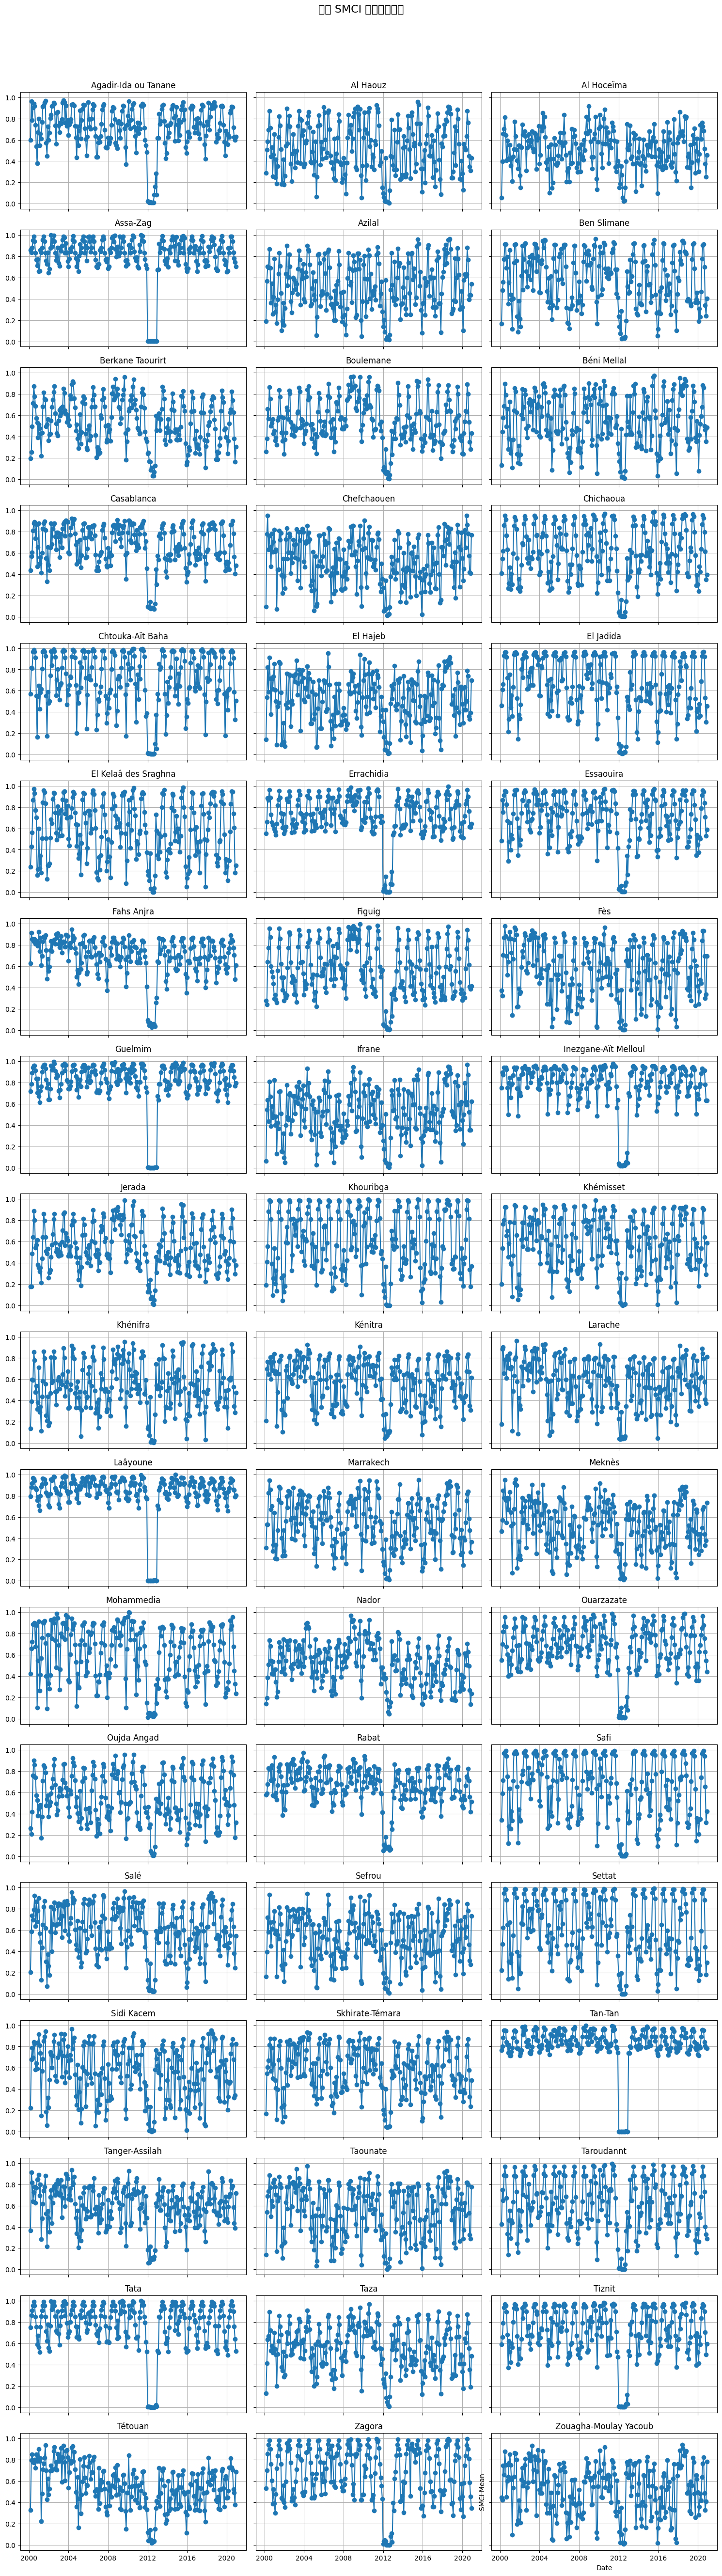

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取 CSV
csv_path = "/content/drive/MyDrive/SoilMoisture_Morocco_SMCI_Provinces1.csv"
df = pd.read_csv(csv_path)

# 解析 YYYYMM 格式的日期
df['Date'] = pd.to_datetime(df['Month'].astype(str), format='%Y%m')

# 按省份和时间排序
df = df.sort_values(by=['Province', 'Date'])

# 获取所有省份列表
provinces = df['Province'].unique()

# 根据省份数量设置子图行数（每行展示 3 个省份）
cols = 3
rows = (len(provinces) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 3 * rows), sharex=True, sharey=True)

for ax, prov in zip(axes.flatten(), provinces):
    df_prov = df[df['Province'] == prov]
    ax.plot(df_prov['Date'], df_prov['SMCI_Mean'], marker='o', linestyle='-')
    ax.set_title(prov)
    ax.grid(True)

# 隐藏多余子图
for ax in axes.flatten()[len(provinces):]:
    ax.set_visible(False)

fig.suptitle("各省 SMCI 月度时间序列", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.xlabel("Date")
plt.ylabel("SMCI Mean")
plt.show()


In [ ]:
import numpy as np
import rasterio

# 假设已经计算好了 month_stats
month = 1  # 例如 2012 年 1 月
sm_min, sm_max = month_stats[month]

# 计算 SM_max - SM_min 的范围
min_val, max_val = np.min(sm_min), np.max(sm_max)
print(f"SM_min 取值范围: {np.min(sm_min)} - {np.max(sm_min)}")
print(f"SM_max 取值范围: {np.min(sm_max)} - {np.max(sm_max)}")
print(f"SM_max - SM_min 取值范围: {np.min(sm_max - sm_min)} - {np.max(sm_max - sm_min)}")



SM_min 取值范围: -1.0 - 359.0
SM_max 取值范围: -1.0 - 406.0
SM_max - SM_min 取值范围: 0.0 - 286.0


In [ ]:
# 安装必要库（如果尚未安装）
!pip install rasterio geopandas pandas matplotlib

import os
import re
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt

# 设定栅格数据目录（原始 SM 数据或 SMCI 数据，这里假设用的是裁剪后的原始 SM 数据）
# 请修改为你的实际目录
data_dir = "/content/drive/MyDrive/data_Macoc"

# 假设文件名中包含类似 ".201201." 这样的格式，其中201201表示年份和月份
pattern = re.compile(r"\.(\d{6})\.")

records = []

# 遍历目录中所有 tif 文件
for filename in os.listdir(data_dir):
    if not filename.endswith(".tif"):
        continue
    match = pattern.search(filename)
    if not match:
        continue
    yearmonth = match.group(1)   # e.g., "201201"
    year = int(yearmonth[:4])
    month = int(yearmonth[4:])
    filepath = os.path.join(data_dir, filename)

    with rasterio.open(filepath) as src:
        # 读取第一波段数据并转为 float
        data = src.read(1).astype(float)
        nodata_val = src.nodata

        # 将 nodata 值替换为 np.nan 以便后续计算
        if nodata_val is not None:
            data[data == nodata_val] = np.nan

        # 计算全局统计指标
        data_min = np.nanmin(data)
        data_max = np.nanmax(data)
        data_mean = np.nanmean(data)

        total_pixels = data.size
        nodata_count = np.isnan(data).sum()
        nodata_fraction = nodata_count / total_pixels

    records.append({
        "filename": filename,
        "year": year,
        "month": month,
        "min": data_min,
        "max": data_max,
        "mean": data_mean,
        "nodata_fraction": nodata_fraction
    })

# 构造 DataFrame，并按照年份和月份排序
df = pd.DataFrame(records)
df.sort_values(by=["year", "month"], inplace=True)
df.reset_index(drop=True, inplace=True)

print("所有文件统计指标预览：")
display(df.head(10))



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 58.5 MB/s eta 0:00:00
所有文件统计指标预览：


filename  year  month  min    max       mean  \
0  SM.1km.Month.200002.Global.v001.tif  2000      2 -1.0  312.0  55.949120   
1  SM.1km.Month.200003.Global.v001.tif  2000      3 -1.0  340.0  57.253721   
2  SM.1km.Month.200004.Global.v001.tif  2000      4 -1.0  353.0  62.278804   
3  SM.1km.Month.200005.Global.v001.tif  2000      5 -1.0  343.0  60.549010   
4  SM.1km.Month.200006.Global.v001.tif  2000      6 -1.0  304.0  54.761357   
5  SM.1km.Month.200007.Global.v001.tif  2000      7 -1.0  307.0  54.060958   
6  SM.1km.Month.200008.Global.v001.tif  2000      8 -1.0  308.0  53.883306   
7  SM.1km.Month.200009.Global.v001.tif  2000      9 -1.0  299.0  54.727278   
8  SM.1km.Month.200010.Global.v001.tif  2000     10 -1.0  333.0  60.395046   
9  SM.1km.Month.200011.Global.v001.tif  2000     11 -1.0  363.0  62.827810   

   nodata_fraction  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  
5              0.0  
6              0.0  
7              0.0  
8              0.0  
9              0.0

from matplotlib import pyplot as plt
_df_0['month'].plot(kind='hist', bins=20, title='month')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['max'].plot(kind='hist', bins=20, title='max')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['mean'].plot(kind='hist', bins=20, title='mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='month', y='max', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='max', y='mean', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['year']
  ys = series['max']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('max')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['year']
  ys = series['mean']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('mean')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['year']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'year'}, axis=1)
              .sort_values('year', ascending=True))
  xs = counted['year']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['month']
  ys = series['max']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('month', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('month')
_ = plt.ylabel('max')

from matplotlib import pyplot as plt
_df_9['month'].plot(kind='line', figsize=(8, 4), title='month')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['max'].plot(kind='line', figsize=(8, 4), title='max')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['mean'].plot(kind='line', figsize=(8, 4), title='mean')
plt.gca().spines[['top', 'right']].set_visible(False)

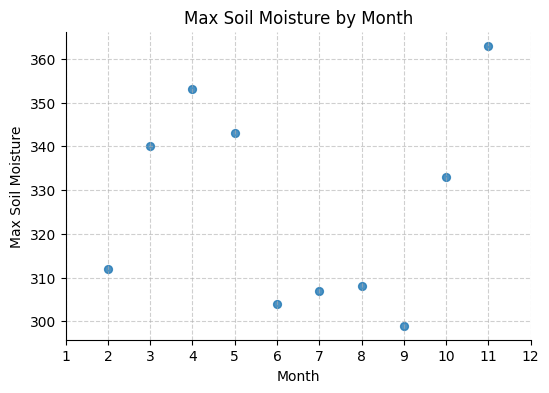

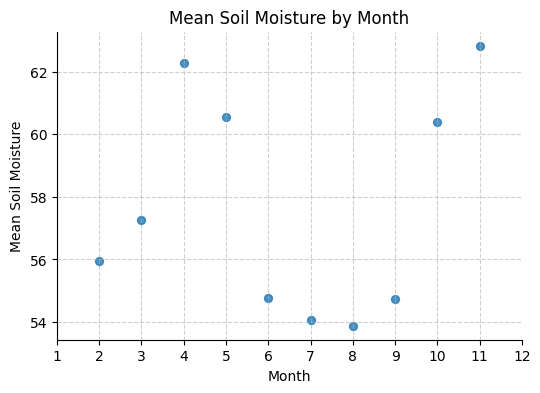

In [ ]:
import matplotlib.pyplot as plt

# 修正 month vs max 散点图
plt.figure(figsize=(6, 4))
plt.scatter(_df_3['month'], _df_3['max'], s=32, alpha=0.8)
plt.xticks(range(1, 13))  # 确保月份正确显示 1-12
plt.xlabel("Month")
plt.ylabel("Max Soil Moisture")
plt.title("Max Soil Moisture by Month")
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

import matplotlib.pyplot as plt

# 修正 month vs mean 散点图
plt.figure(figsize=(6, 4))
plt.scatter(_df_3['month'], _df_3['mean'], s=32, alpha=0.8)
plt.xticks(range(1, 13))  # 确保月份正确显示 1-12
plt.xlabel("Month")
plt.ylabel("Mean Soil Moisture")
plt.title("Mean Soil Moisture by Month")
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()



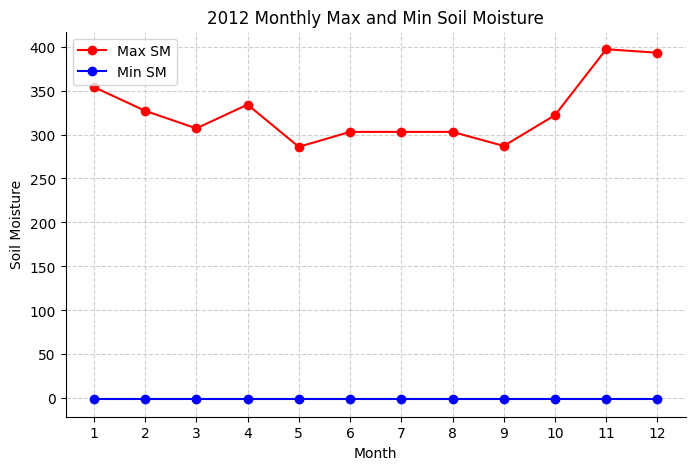

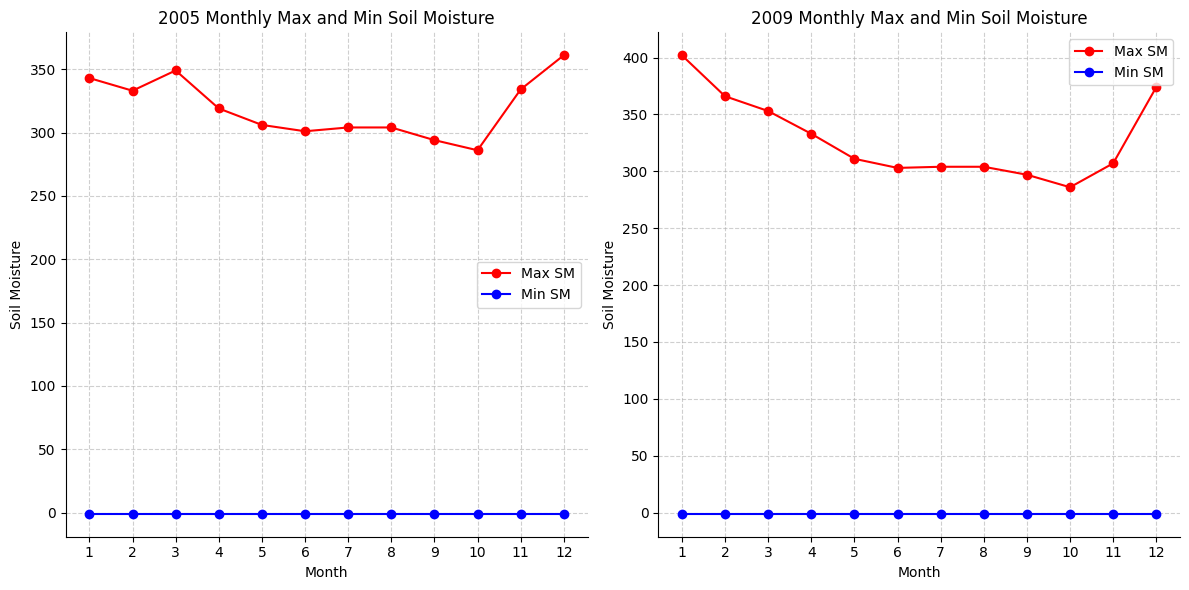

In [ ]:
import matplotlib.pyplot as plt

# 筛选出 2012 年的数据
df_2012 = df[df['year'] == 2012]

# 画图
plt.figure(figsize=(8, 5))
plt.plot(df_2012['month'], df_2012['max'], marker='o', linestyle='-', label="Max SM", color='red')
plt.plot(df_2012['month'], df_2012['min'], marker='o', linestyle='-', label="Min SM", color='blue')

# 设置刻度、标签和标题
plt.xticks(range(1, 13))  # 确保 X 轴显示 1-12 月
plt.xlabel("Month")
plt.ylabel("Soil Moisture")
plt.title("2012 Monthly Max and Min Soil Moisture")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()
import matplotlib.pyplot as plt

# 筛选出 2005 年和 2009 年的数据
df_2005 = df[df['year'] == 2005]
df_2009 = df[df['year'] == 2009]

# 画图
plt.figure(figsize=(12, 6))

# 2005 年的数据
plt.subplot(1, 2, 1)
plt.plot(df_2005['month'], df_2005['max'], marker='o', linestyle='-', label="Max SM", color='red')
plt.plot(df_2005['month'], df_2005['min'], marker='o', linestyle='-', label="Min SM", color='blue')
plt.xticks(range(1, 13))  # 确保 X 轴显示 1-12 月
plt.xlabel("Month")
plt.ylabel("Soil Moisture")
plt.title("2005 Monthly Max and Min Soil Moisture")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().spines[['top', 'right']].set_visible(False)

# 2009 年的数据
plt.subplot(1, 2, 2)
plt.plot(df_2009['month'], df_2009['max'], marker='o', linestyle='-', label="Max SM", color='red')
plt.plot(df_2009['month'], df_2009['min'], marker='o', linestyle='-', label="Min SM", color='blue')
plt.xticks(range(1, 13))  # 确保 X 轴显示 1-12 月
plt.xlabel("Month")
plt.ylabel("Soil Moisture")
plt.title("2009 Monthly Max and Min Soil Moisture")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
df[df['min'] == 0]['Province'].value_counts()


KeyError: 'Province'

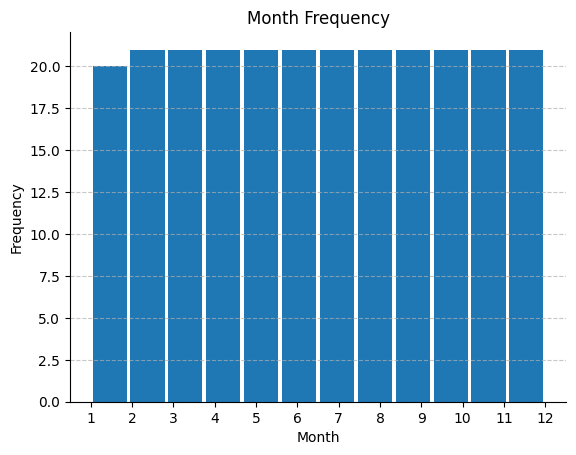

In [ ]:
df['month'].plot(kind='hist', bins=12, title='Month Frequency', rwidth=0.9)
plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()


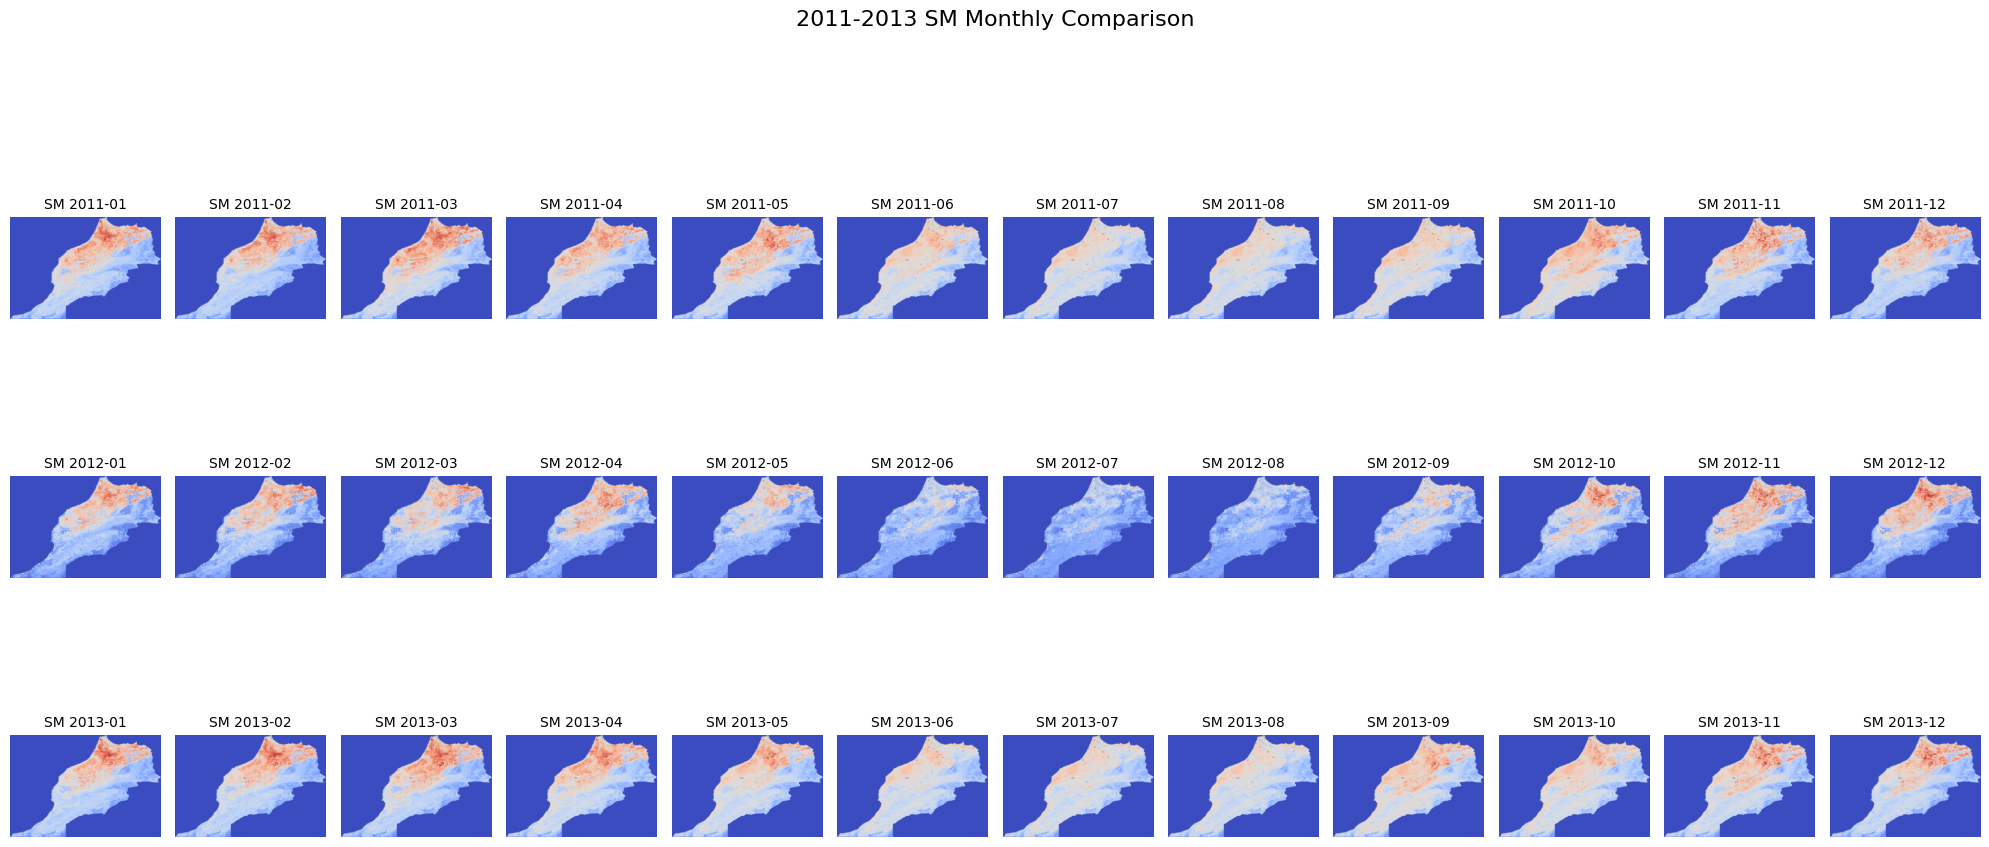

In [ ]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show

# 数据路径
sm_path = "/content/drive/MyDrive/data/morocco_clipped"

# 获取所有 TIFF 文件
sm_files = sorted([f for f in os.listdir(sm_path) if f.endswith(".tif")])

# 提取年份和月份信息
def extract_data(files, base_path):
    data_dict = {}
    for file_name in files:
        parts = file_name.split('.')
        if len(parts) >= 5 and parts[3].isdigit():
            year, month = int(parts[3][:4]), int(parts[3][4:6])
            if 2011 <= year <= 2013:
                data_dict.setdefault(year, {})[month] = os.path.join(base_path, file_name)
    return data_dict

sm_data = extract_data(sm_files, sm_path)

# 创建图表
fig, axes = plt.subplots(nrows=3, ncols=12, figsize=(20, 10))
fig.suptitle("2011-2013 SM Monthly Comparison", fontsize=16)

for i, year in enumerate(sorted(sm_data.keys())):
    for month in range(1, 13):
        sm_file = sm_data[year].get(month)

        ax = axes[i, month - 1]
        if sm_file and os.path.exists(sm_file):
            with rasterio.open(sm_file) as src:
                sm_data_array = src.read(1).astype(float)
                sm_data_array[sm_data_array == -1] = np.nan
                sm_data_array[sm_data_array < 0] = np.nan  # 确保所有无效值都不显示

                # 仅显示有效数据部分，颜色映射与 SMCI 保持一致（蓝色低值，红色高值）
                masked_data = np.ma.masked_invalid(sm_data_array)
                show(masked_data, ax=ax, cmap='coolwarm')
                ax.set_title(f"SM {year}-{month:02d}", fontsize=10)
                ax.axis("off")
        else:
            ax.set_title("No Data", fontsize=10)
            ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()